In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as smp
import plotly 
import pandas as pd
import pickle
import edist.ted as ted
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append("../src")

import utils
import ExpressionTree

import re

In [3]:
def t1(X):
    return 10*np.exp(-0.5*np.exp(-0.5*X + 2))
X1 = np.linspace(-5, 15, 140)
y1 = t1(X1)

def t2(X):
    return np.exp(-X)
X2 = np.linspace(1, 20, 140)
y2 = t2(X2)

air_passengers = pd.read_csv("data/AirPassengers.csv")
X3 = air_passengers.index
y3 = air_passengers["#Passengers"]

treated_seco = pd.read_csv("data/treated_seco.csv")
treated_seco

treated_seco["eventdate"] = pd.to_datetime(treated_seco["eventdate"])
treated_seco.set_index("eventdate", inplace=True, drop=True)
treated_seco = treated_seco.asfreq("7D")
treated_seco.rename(columns={"Unnamed: 0": "weeks"}, inplace=True)

X4_origin = treated_seco.weeks.values
y4_origin = treated_seco.value.values

X4 = treated_seco.weeks[::2].values
y4 = treated_seco.value[::2].values


# sugar = yf.Ticker("SB=F")
# sugar_history = sugar.history(period="1y")
# sugar_history = sugar_history.asfreq("B")

# # Interpolando os dados
# sugar_history = sugar_history.interpolate()

# sugar_history.reset_index(inplace=True)

sugar_data_manip = pd.read_csv("data/sugar_data_manip.csv")
X5 = sugar_data_manip.X.values
y5 = sugar_data_manip.y.values

data = [
    [X3, y3],
    [X4, y4],
    [X5, y5]
]

<Axes: >

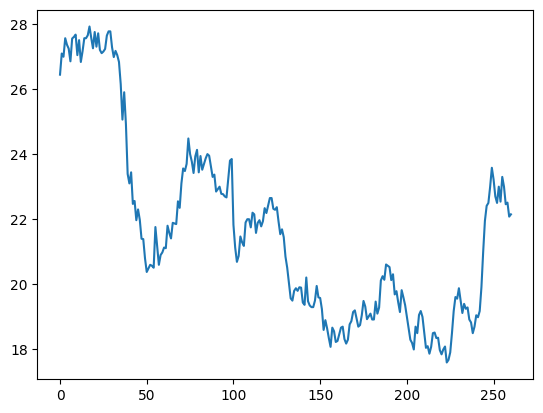

In [11]:
sns.lineplot(x=X5,y=y5)

In [3]:
def create_df(path):
    with open(path, "rb") as file:
        air_info = pickle.load(file)

    interval = list(air_info.keys())
    funcs = list(air_info.values())

    air_df = pd.DataFrame()
    air_df["interval"] = interval
    air_df["func"] = funcs


    x0 = smp.symbols("x0")
    air_lamb = []

    for i, row in air_df.iterrows():
        lamb = smp.lambdify([x0], row.func)   
        air_lamb.append(lamb)

    air_df["lamb"] = air_lamb

    starts, ends, iters = [], [], []
    pattern = re.compile(r"\d+")
    for row in air_df["interval"]:
        start, end, it = pattern.findall(row)
        
        starts.append(int(start))
        ends.append(int(end))
        iters.append(int(it))

    air_df["start"] = starts
    air_df["end"] = ends
    air_df["iteration"] = iters
    air_df.drop("interval", axis=1, inplace=True)

    sizes = []
    for row in air_df["func"]:
        size = len(utils.exprToTree(row))
        sizes.append(int(size))

    air_df["size"] = sizes

    return air_df

In [4]:
dfs = []
for i in range(0, 2):
    path = rf"E:\Documents\Coding\Repositorios\MyRepositories\Versatus\Janela_Movel\SRRollingMetric\Outputs\Airplane\RollingMetric-120-85-{i}.pkl"
    df = create_df(path)
    dfs.append(df)

In [5]:
air_df = pd.concat(dfs).sort_values("end").reset_index(drop=True)
air_df.head()

func  \
0  (x0 + (x0 + 18.1020192150762*sin(x0) + 183.273...   
1  (x0 + 286.20352*exp(sin(0.537315890053563*x0))...   
2  (0.3149186*x0 - 20.8247973569416)*exp(exp(-sin...   
3  x0 + 11.3903134860549*exp(exp(-cos(0.521923528...   
4  x0 + 62.3682101984737*sin(0.508369593641883*x0...   

                                                lamb  start  end  iteration  \
0  <function _lambdifygenerated at 0x000002163071...    120   85          0   
1  <function _lambdifygenerated at 0x000002163087...    120   85          1   
2  <function _lambdifygenerated at 0x000002163071...    120   85          0   
3  <function _lambdifygenerated at 0x000002163071...    120   86          0   
4  <function _lambdifygenerated at 0x000002163071...    120   86          1   

   size  
0    26  
1    19  
2    18  
3    14  
4    17

# Complexity

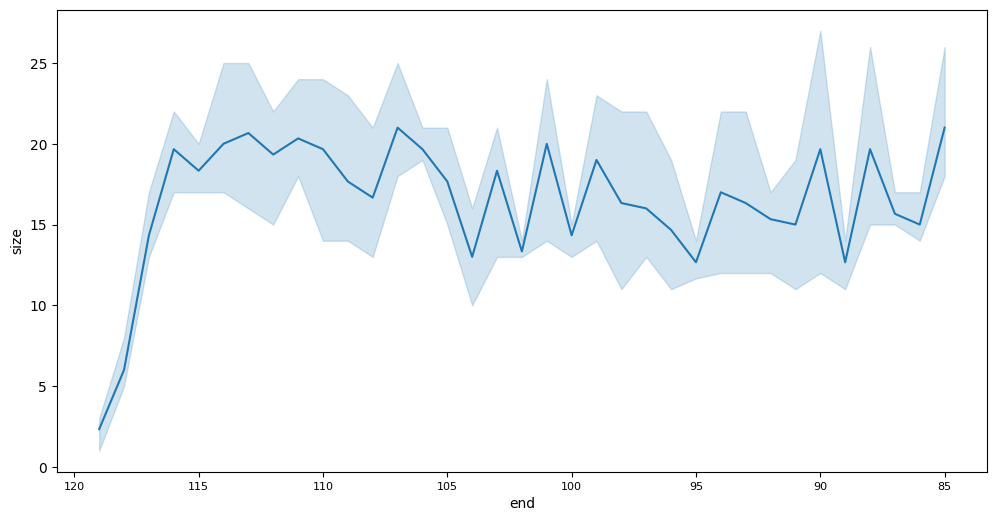

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(air_df, x="end", y="size")
plt.xticks(fontsize=8)
plt.gca().invert_xaxis()
plt.show()

2024-10-19 19:38:47,064 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-19 19:38:47,079 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


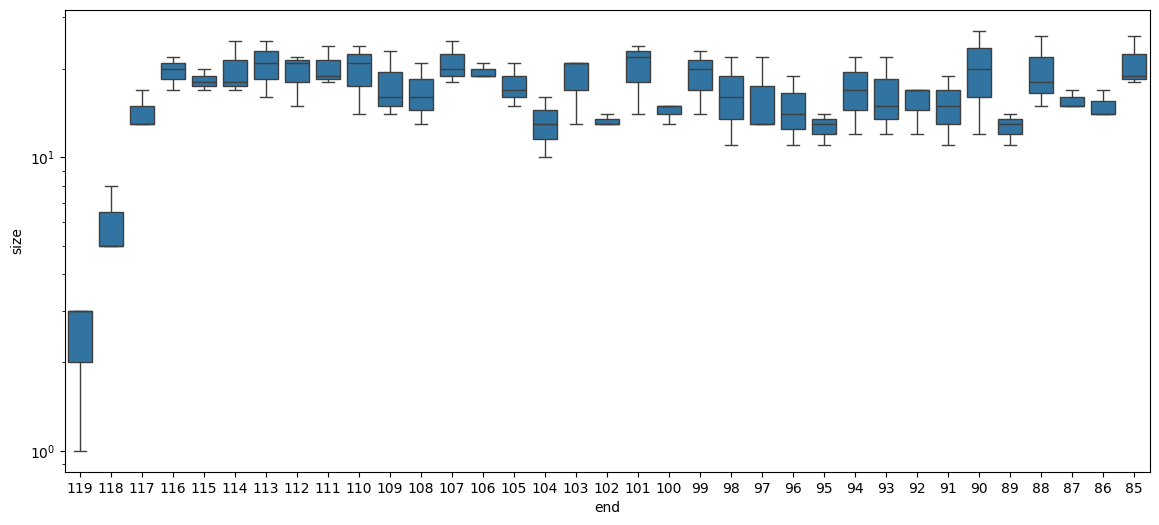

In [7]:
plt.figure(figsize=(14,6))
sns.lineplot(air_df, x="end", y="size", c="black", linestyle="--", errorbar=None)
sns.boxplot(data=air_df, x="end", y="size")
plt.yscale("log")
plt.gca().invert_xaxis()

# MSE

In [8]:
def calculate_MSE(X, y, a, b, func):
    X = X[a:b]
    y = y[a:b]
    y_pred = func(X)

    return np.mean((y - y_pred)**2)

In [9]:
MSEs = []
for i, row in air_df.iterrows():
    MSE = calculate_MSE(X3, y3, row.end, row.start, row.lamb)
    MSEs.append(MSE)

air_df["MSE"] = MSEs

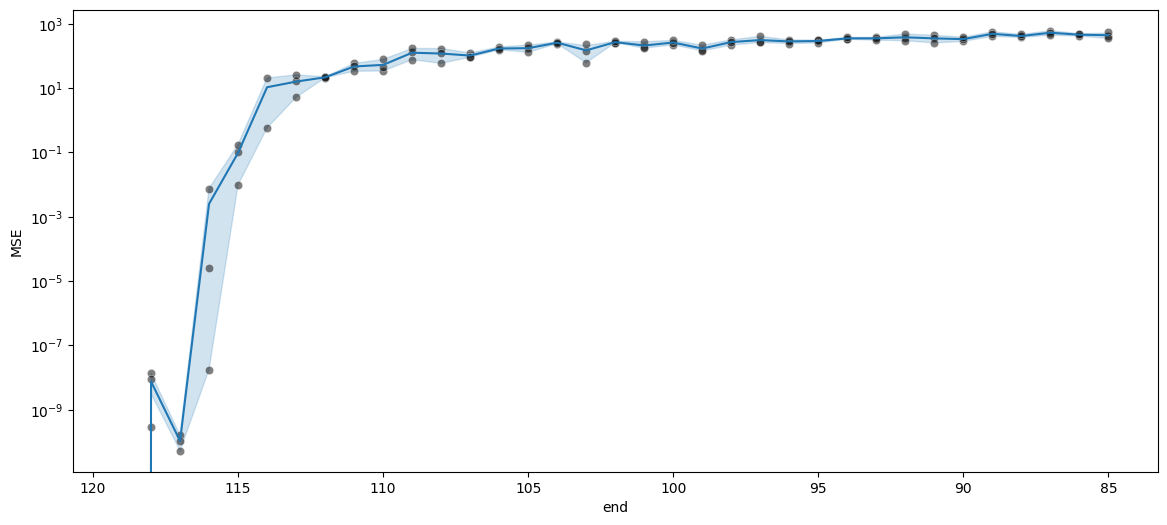

In [110]:
plt.figure(figsize=(14, 6))
sns.lineplot(air_df, x="end", y="MSE")
sns.scatterplot(air_df, x="end", y="MSE", alpha=0.5, c="black")
plt.yscale("log")
plt.gca().invert_xaxis()

2024-10-19 19:38:49,768 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-10-19 19:38:49,779 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


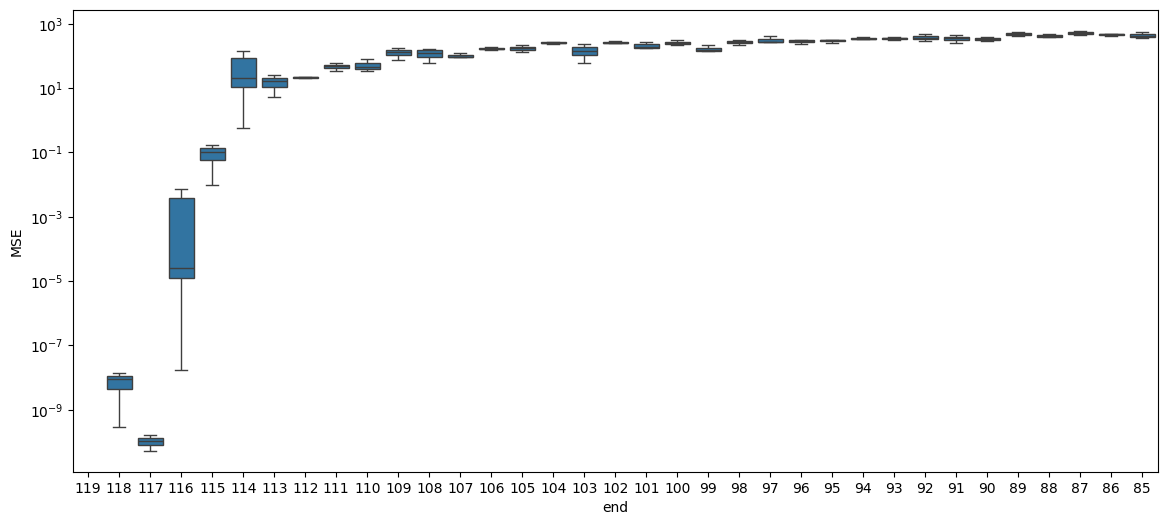

In [11]:
plt.figure(figsize=(14, 6))
sns.boxplot(air_df, x="end", y="MSE")
plt.yscale("log")
plt.gca().invert_xaxis()

In [106]:
air_df_filtered = air_df[air_df["end"] <= 105]

import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

#Calculate ys
ys = []
X_range = np.linspace(0, 400, 401)

for i, row in air_df_filtered.iterrows():
    y = row.lamb(X_range)

    try:
        len(y)
    except:
        y = [y for _ in X_range]

    ys.append(y)

# Add traces for each Y column
c = 0
for i, row in air_df_filtered.iterrows():
    fig.add_trace(go.Scatter(x=X_range, y=ys[c], name=f"{c}"))
    c += 1

# Create dropdown
# Set the initial y-axis range
fig.update_layout(yaxis=dict(range=[-200, 600]))  # Default y-axis range

fig.update_layout(
    width=1200,  # Set the width of the plot
    height=600,  # Set the height of the plot
)

# Add slider for controlling the y-axis range
fig.update_layout(
    sliders=[
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Min: '},
            'pad': {'t': 50},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[0]': i}]} 
                for i in range(-200, 200)  # Min y value range (0 to 20)
            ]
        },
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Max: '},
            'pad': {'t': 100},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[1]': i}]} 
                for i in range(0, 700)  # Max y value range (20 to 50)
            ]
        }
    ]
)

# Set the title and display the figure
fig.update_layout(title='Interactive Data Selection')
fig.show()




In [56]:
filtered = air_df[air_df["iteration"] == 0]
filtered.gead

func  \
0    (x0 + (x0 + 18.1020192150762*sin(x0) + 183.273...   
2    (0.3149186*x0 - 20.8247973569416)*exp(exp(-sin...   
3    x0 + 11.3903134860549*exp(exp(-cos(0.521923528...   
5    2.0*x0 + 11.299152*exp(exp(sin(0.5072112*x0)))...   
6    2.7305326*x0 + 1.8126134 + 62.4643796874832*ex...   
..                                                 ...   
98   -2.9924867*cos(x0) + 347.25122 - 6.9382596/cos...   
100                           26.999872*x0 - 2875.9849   
101                       293.5756 - 16.127998/sin(x0)   
102                                   337.000000000000   
103                                         x0 + 218.0   

                                                  lamb  start  end  iteration  \
0    <function _lambdifygenerated at 0x000002163071...    120   85          0   
2    <function _lambdifygenerated at 0x000002163071...    120   85          0   
3    <function _lambdifygenerated at 0x000002163071...    120   86          0   
5    <function _lambdifygenerated at 0x000002163071...    120   86          0   
6    <function _lambdifygenerated at 0x000002163071...    120   87          0   
..                                                 ...    ...  ...        ...   
98   <function _lambdifygenerated at 0x000002163071...    120  117          0   
100  <function _lambdifygenerated at 0x000002163070...    120  118          0   
101  <function _lambdifygenerated at 0x000002163071...    120  118          0   
102  <function _lambdifygenerated at 0x000002163062...    120  119          0   
103  <function _lambdifygenerated at 0x00000216304E...    120  119          0   

     size           MSE                                               diff  \
0      26  4.187209e+02  -0.5375961*(x0 + (x0 + 18.1020192150762*sin(x0...   
2      18  3.500900e+02  -0.522349125201026*(0.3149186*x0 - 20.82479735...   
3      14  4.656702e+02  5.94487260293175*exp(exp(-cos(0.52192352828655...   
5      14  4.929381e+02  5.7310564449024*exp(exp(sin(0.5072112*x0)))*ex...   
6      15  6.092890e+02  2.7305326 - 33.6013488308292*exp(-sin(0.537928...   
..    ...           ...                                                ...   
98     13  1.047383e-10   2.9924867*sin(x0) - 6.9382596*sin(x0)/cos(x0)**2   
100     5  8.720000e-09                                   26.9998720000000   
101     8  2.879927e-10                       16.127998*cos(x0)/sin(x0)**2   
102     1  0.000000e+00                                                  0   
103     3  0.000000e+00                                                  1   

                                             diff_lamb      MSE_diff  
0    <function _lambdifygenerated at 0x000002163093...    255.727969  
2    <function _lambdifygenerated at 0x00000216309C...    319.022544  
3    <function _lambdifygenerated at 0x00000216309C...    311.643779  
5    <function _lambdifygenerated at 0x00000216309C...    371.862106  
6    <function _lambdifygenerated at 0x00000216309C...    320.938151  
..                                                 ...           ...  
98   <function _lambdifygenerated at 0x00000216352F...  14290.504360  
100  <function _lambdifygenerated at 0x00000216352F...    723.994880  
101  <function _lambdifygenerated at 0x00000216352F...   3591.140170  
102  <function _lambdifygenerated at 0x00000216352F...    625.000000  
103  <function _lambdifygenerated at 0x00000216352F...    576.000000  

[69 rows x 10 columns]

In [57]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

#Calculate ys
ys = []
X_range = np.linspace(0, 400, 401)

for i, row in air_df[air_df["iteration"] == 1].iterrows():
    y = row.lamb(X_range)

    try:
        len(y)
    except:
        y = [y for _ in X_range]

    ys.append(y)

# Add traces for each Y column
c = 0
for i, row in air_df[air_df["iteration"] == 1].iterrows():
    fig.add_trace(go.Scatter(x=X_range, y=ys[c], name=f"{c}"))
    c += 1

# Create dropdown
# Set the initial y-axis range
fig.update_layout(yaxis=dict(range=[-200, 600]))  # Default y-axis range

fig.update_layout(
    width=1200,  # Set the width of the plot
    height=600,  # Set the height of the plot
)

# Add slider for controlling the y-axis range
fig.update_layout(
    sliders=[
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Min: '},
            'pad': {'t': 50},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[0]': i}]} 
                for i in range(-200, 200)  # Min y value range (0 to 20)
            ]
        },
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Max: '},
            'pad': {'t': 100},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[1]': i}]} 
                for i in range(0, 700)  # Max y value range (20 to 50)
            ]
        }
    ]
)

# Set the title and display the figure
fig.update_layout(title='Interactive Data Selection')
fig.show()



<lambdifygenerated-63>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-57>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-43>:2: RuntimeWarning:

invalid value encountered in divide



## Derivative

In [29]:
diffs = []
diffs_lamb = []

x0 = smp.symbols("x0")

for i, row in air_df.iterrows():
    expr = row.func
    expr_diff = expr.diff("x0")
    diff_lamb = smp.lambdify([x0], expr_diff)
    diffs.append(expr_diff)
    diffs_lamb.append(diff_lamb)

air_df["diff"] = diffs
air_df["diff_lamb"] = diffs_lamb

# Seco

In [12]:
dfs = []
for i in range(0, 2):
    path = rf"E:\Documents\Coding\Repositorios\MyRepositories\Versatus\Janela_Movel\SRRollingMetric\Outputs\Seco\RollingMetric-108-49-{i}.pkl"
    df = create_df(path)
    dfs.append(df)

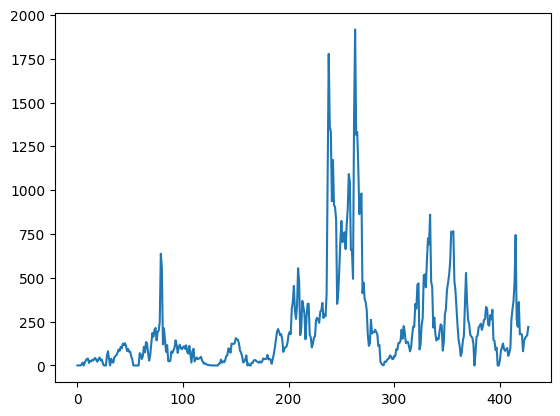

In [85]:
len(X4)
X4_new = np.linspace(0, 427, 428)
plt.plot(X4_new, y4)

In [93]:
import plotly.graph_objects as go

# Assuming X4 and y4 are already defined

fig = go.Figure()

# Plot the full dataset
fig.add_trace(go.Scatter(x=X4_origin, y=y4_origin, mode='lines', name='Full Data'))

# Plot the subset (index 49 to 107)
fig.add_trace(go.Scatter(x=X4_origin[167:216], y=y4_origin[167:216], mode='lines', name='Subset'))

# Customize the layout (optional)
fig.update_layout(
    title="Plot with Subset",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    width=800,
    height=600
)

# Show the figure
fig.show()


In [13]:
seco_df = pd.concat(dfs).sort_values("end").reset_index(drop=True)
seco_df.head()

func  \
0  x0*exp(-sin(2.54344813483225*sin(exp(sin(0.090...   
1  x0/(exp(cos(exp(-cos(56.4880764120988*x0))*sin...   
2  x0*exp(-cos(exp(cos(0.08059247*x0))))*cos(sin(...   
3  1.31984196159558*x0*exp(cos(4.0086827*sin(2.45...   
4  x0*exp(sin(0.090456806*x0))*sin(exp(-sin(0.155...   

                                                lamb  start  end  iteration  \
0  <function _lambdifygenerated at 0x000002163379...    108   49          0   
1  <function _lambdifygenerated at 0x00000216352C...    108   49          1   
2  <function _lambdifygenerated at 0x00000216352C...    108   49          0   
3  <function _lambdifygenerated at 0x000002163379...    108   50          0   
4  <function _lambdifygenerated at 0x00000216352C...    108   50          1   

   size  
0    21  
1    23  
2    17  
3    15  
4    16

In [113]:
seco_df["end"].describe()

count    177.000000
mean      78.000000
std       17.077697
min       49.000000
25%       63.000000
50%       78.000000
75%       93.000000
max      107.000000
Name: end, dtype: float64

In [111]:
seco_df_filtered = seco_df[seco_df["end"] <= 70]

fig = go.Figure()

X_range = np.linspace(0, 300, 301)
for i, row in seco_df_filtered.iterrows():
    y = row.lamb(X_range)

    try:
        len(y)
    except:
        y = [y for _ in X_range]

    # plt.plot(X_range, y)
    fig.add_trace(go.Scatter(x=X_range, y=y, name=f"{i}"))

fig.update_layout(yaxis=dict(range=[-200, 600]))  # Default y-axis range

fig.update_layout(
    width=1200,  # Set the width of the plot
    height=600,  # Set the height of the plot
)

# Add slider for controlling the y-axis range
fig.update_layout(
    sliders=[
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Min: '},
            'pad': {'t': 50},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[0]': i}]} 
                for i in range(-1000, 0)  # Min y value range (0 to 20)
            ]
        },
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Max: '},
            'pad': {'t': 100},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[1]': i}]} 
                for i in range(0, 1000)  # Max y value range (20 to 50)
            ]
        }
    ]
)

# Set the title and display the figure
fig.update_layout(title='Interactive Data Selection')


fig.show()

<lambdifygenerated-161>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-264>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-154>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-153>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-256>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-151>:2: RuntimeWarning:

invalid value encountered in divide

<lambdifygenerated-253>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-253>:2: RuntimeWarning:

invalid value encountered in cos

<lambdifygenerated-244>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-145>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-144>:2: RuntimeWarning:

divide by zero encountered in divide



In [114]:
fig = go.Figure()

X_range = np.linspace(0, 300, 301)
for i, row in seco_df.iterrows():
    y = row.lamb(X_range)

    try:
        len(y)
    except:
        y = [y for _ in X_range]

    # plt.plot(X_range, y)
    fig.add_trace(go.Scatter(x=X_range, y=y, name=f"{i}"))

fig.update_layout(yaxis=dict(range=[-200, 600]))  # Default y-axis range

fig.update_layout(
    width=1200,  # Set the width of the plot
    height=600,  # Set the height of the plot
)

# Add slider for controlling the y-axis range
fig.update_layout(
    sliders=[
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Min: '},
            'pad': {'t': 50},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[0]': i}]} 
                for i in range(-1000, 0)  # Min y value range (0 to 20)
            ]
        },
        {
            'active': 0,
            'currentvalue': {'prefix': 'Y-axis Max: '},
            'pad': {'t': 100},
            'steps': [
                {'label': str(i), 'method': 'relayout', 'args': [{'yaxis.range[1]': i}]} 
                for i in range(0, 1000)  # Max y value range (20 to 50)
            ]
        }
    ]
)

# Set the title and display the figure
fig.update_layout(title='Interactive Data Selection')


fig.show()

<lambdifygenerated-161>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-264>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-154>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-153>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-256>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-151>:2: RuntimeWarning:

invalid value encountered in divide

<lambdifygenerated-253>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-253>:2: RuntimeWarning:

invalid value encountered in cos

<lambdifygenerated-244>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-145>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-144>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-237>:2: RuntimeWarning:

divide by zero encountered in divide

<lambdifygenerated-23

# Complexity

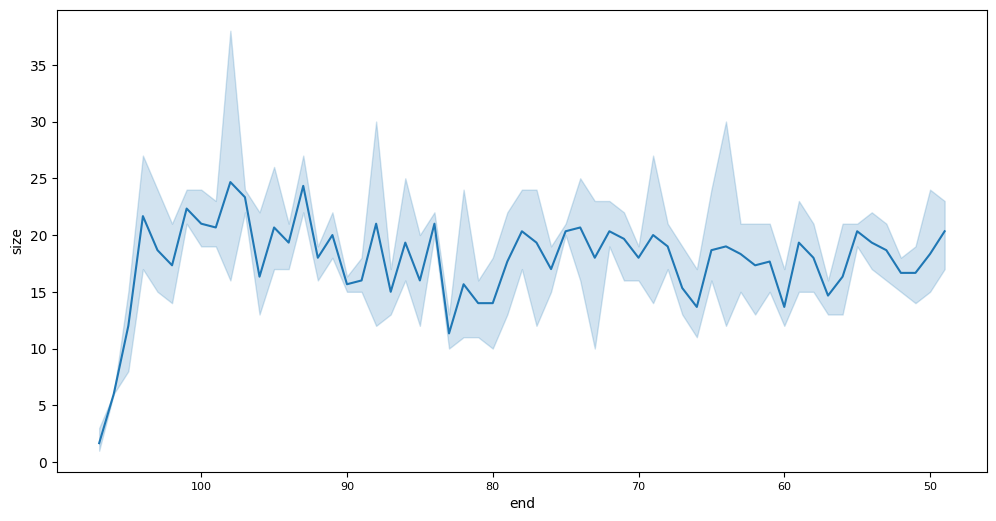

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(seco_df, x="end", y="size")
plt.xticks(fontsize=8)
plt.gca().invert_xaxis()
plt.show()

2024-10-19 20:55:13,535 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-10-19 20:55:13,550 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


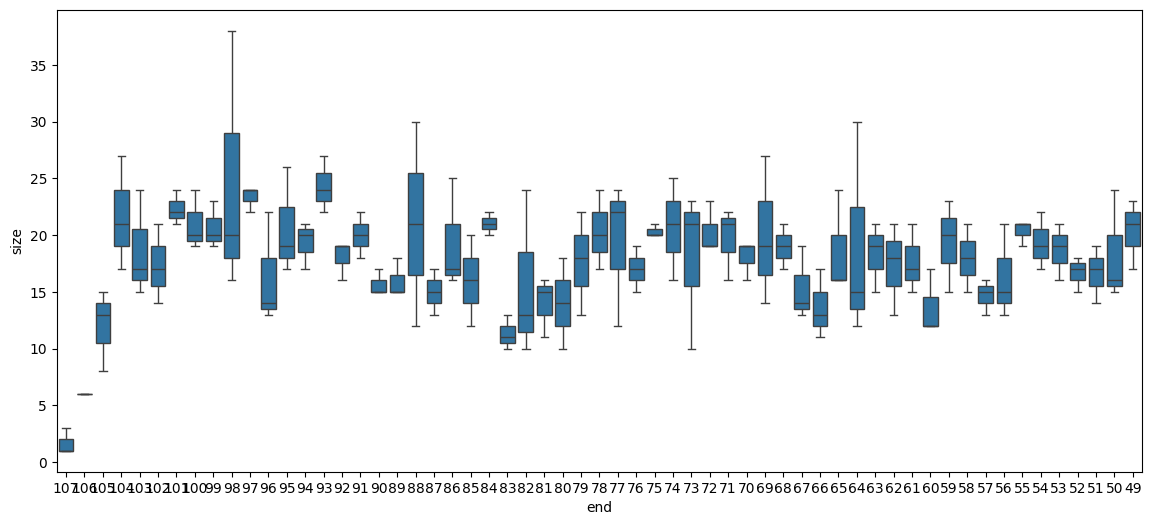

In [103]:
plt.figure(figsize=(14,6))
# sns.lineplot(data=seco_df, x="end", y="size", c="black", linestyle="--", errorbar=None)
sns.boxplot(data=seco_df, x="end", y="size")
# plt.yscale("log")
plt.gca().invert_xaxis()

# MSE

In [16]:
def calculate_MSE(X, y, a, b, func):
    X = X[a:b]
    y = y[a:b]
    y_pred = func(X)

    return np.mean((y - y_pred)**2)

In [22]:
MSEs = []
for i, row in seco_df.iterrows():
    MSE = calculate_MSE(X4, y4, row.end, row.start, row.lamb)
    MSEs.append(MSE)

seco_df["MSE"] = MSEs

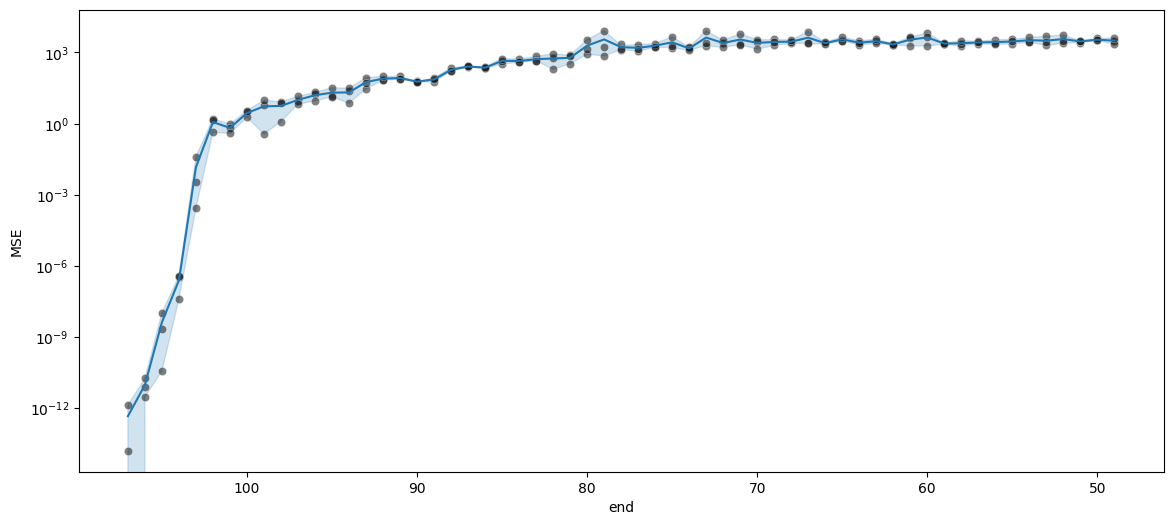

In [24]:
plt.figure(figsize=(14, 6))
sns.lineplot(seco_df, x="end", y="MSE")
sns.scatterplot(seco_df, x="end", y="MSE", alpha=0.5, c="black")
plt.yscale("log")
plt.gca().invert_xaxis()

2024-10-19 19:41:33,250 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-19 19:41:33,260 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


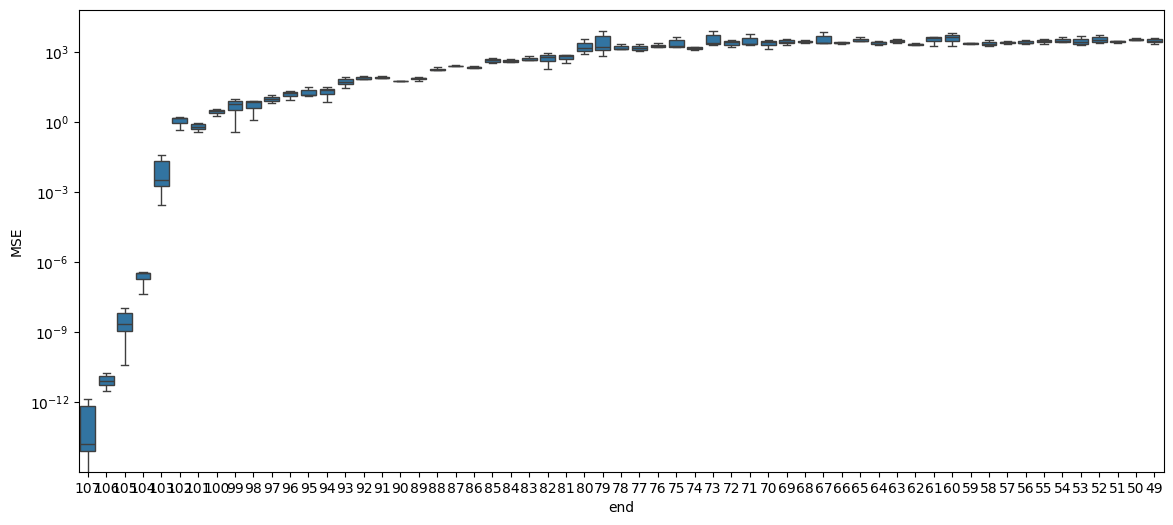

In [26]:
plt.figure(figsize=(14, 6))
sns.boxplot(seco_df, x="end", y="MSE")
plt.yscale("log")
plt.gca().invert_xaxis()